<a href="https://colab.research.google.com/github/AlexGrig/practical-rl/blob/master/hw-1-deep-crossentropy-method/hw-1-deep-crossentropy-method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://tip.duke.edu/independent_learning/greek/lesson/digging_deeper_final.jpg)


In [5]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

bash: ../xvfb: No such file or directory


In [6]:
#!pip install gym[toy_text]

In [7]:
!df -h

Filesystem      Size   Used  Avail Capacity iused      ifree %iused  Mounted on
/dev/disk1s1   466Gi   10Gi  131Gi     8%  488003 4881964877    0%   /
devfs          192Ki  192Ki    0Bi   100%     665          0  100%   /dev
/dev/disk1s2   466Gi  322Gi  131Gi    72% 1018643 4881434237    0%   /System/Volumes/Data
/dev/disk1s5   466Gi  2.0Gi  131Gi     2%       2 4882452878    0%   /private/var/vm
map auto_home    0Bi    0Bi    0Bi   100%       0          0  100%   /System/Volumes/Data/home


In [8]:
!cat /proc/cpuinfo

cat: /proc/cpuinfo: No such file or directory


In [9]:
!cat /proc/meminfo

cat: /proc/meminfo: No such file or directory


state vector dim = 4
n_actions = 2


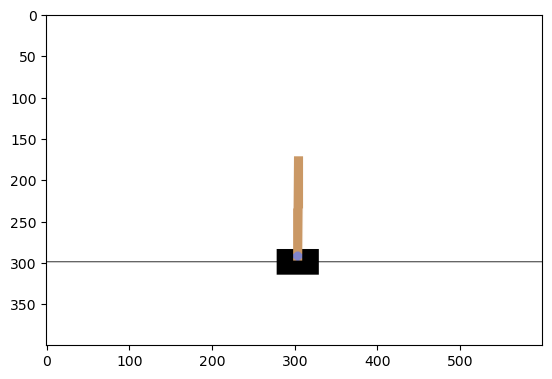

In [10]:
import time
import gym
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v1", new_step_api=True, render_mode='rgb_array')

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render()[0])
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

In [11]:
env.observation_space, env.action_space

(Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32),
 Discrete(2))

In [12]:
[env.reset()] * n_actions, range(n_actions), range(n_actions)

([array([-0.03292033,  0.01959273, -0.01617348,  0.01995891], dtype=float32),
  array([-0.03292033,  0.01959273, -0.01617348,  0.01995891], dtype=float32)],
 range(0, 2),
 range(0, 2))

In [13]:
env.reset()

array([ 0.03574516, -0.00774034,  0.00754958, -0.03926654], dtype=float32)

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probabilitity of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__

You may also use your favorite neural framework, if it doesn't make it too difficult. The idea is the main thing.

In [14]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [15]:
env.reset().reshape(1, -1)

array([[ 0.00070878,  0.04849555, -0.02786877,  0.00637338]],
      dtype=float32)

In [16]:
agent.predict_proba(env.reset().reshape(1, -1)).squeeze()

array([0.40091654, 0.59908346])

In [17]:
ll = env.step(1)
len(ll)

5

In [18]:
ll[4]

{}

In [19]:
def generate_session(agent, t_max=1000, renderer=False, test=False, new_environment=False, env=None):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    renderer (bool or video recorder): if not bool then call capture_frame.
    new_environment (bool): If we use joblib, we need this in order to parallel execution
    env (env): existing environment
    """
    states, actions = [], []
    total_reward = 0
    episode_len = -1

    if new_environment:
      env = gym.make("CartPole-v1", new_step_api=True, render_mode='rgb_array') # make new environment here to use parallel execution.
    else:
      env=env

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba(s.reshape(1, -1)).squeeze()  #<YOUR CODE>

        assert probs.shape == (n_actions,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        if test:
            # on the test use the best (the most likely) actions at test
            # experiment, will it work on the train and vice versa?
            a = np.argmax( probs ) #<YOUR CODE>
            # ^-- hint: try np.argmax
        else:
            # sample proportionally to the probabilities,
            # don't just take the most likely action at train
            a = np.random.choice(np.arange(0, n_actions), p=probs )
            # ^-- hint: try np.random.choice

        
        new_s, r, done, truenc, info = env.step(a)

        if isinstance(renderer, bool):
          if renderer:
            plt.imshow(env.render())
        else:
          renderer.capture_frame()
          
        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s

        if done: # we can compute session's statistics
            episode_len = t
            break
    if episode_len == -1:
      episode_len = t_max
    if renderer:
        env.close()

    return states, actions, total_reward, episode_len

In [20]:
dummy_states, dummy_actions, dummy_reward, episode_len = generate_session(agent, t_max=5, env=env)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)
print("episode len:", episode_len)

states: [[ 0.02476324 -0.03433153 -0.04213828 -0.01371916]
 [ 0.02407661  0.16136861 -0.04241266 -0.31939378]
 [ 0.02730398 -0.03312445 -0.04880054 -0.04038214]
 [ 0.02664149  0.1626621  -0.04960818 -0.348054  ]
 [ 0.02989473  0.35845324 -0.05656926 -0.65595824]]
actions: [1, 0, 1, 1, 1]
reward: 5.0
episode len: 5


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

Let's see that it differs from tabular `select_elites`. Our neural network now is trained with one object and it takes an input of `(1, n_states)`. So, we should use `np.squeeze` to remove leading dimension in the deep `select_elites`.

In [21]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    #<YOUR CODE>
    threshold = np.percentile(rewards_batch, percentile)
    
    #states_batch = np.array(states_batch)
    #actions_batch = np.array(actions_batch)
    rewards_batch = np.array(rewards_batch)
    mask = rewards_batch >= threshold # we might need to further improve mask to include less samples if they are all equal

    elite_states = [np.array(states_batch[ii]) for ii in range(len(states_batch)) if mask[ii]>0 ]
    #elite_states = states_batch[mask]
    elite_states = np.vstack(elite_states)
    elite_actions = [np.array(actions_batch[ii]) for ii in range(len(actions_batch)) if mask[ii]>0 ]
    elite_actions = np.hstack(elite_actions) #np.array(sum(elite_actions, [])).reshape(-1,1) # need 1 dim Y's for NN.

    # Let's see that it differs from tabular `select_elites`.
    # Our neural network now is trained with one object and it takes an input of `(1, n_states)`.
    # So, we should use `np.squeeze` to remove leading dimension in the deep `select_elites`.
    
    return elite_states, elite_actions

In [22]:
sessions = [generate_session(agent, t_max=5, renderer=False, test=False, env=env) for _ in range(0, 3)]
states_batch, actions_batch, rewards_batch, episode_len_batch = zip(*sessions)
ss, aa = select_elites(states_batch, actions_batch, rewards_batch, percentile=50)


In [23]:
states_batch, actions_batch, rewards_batch

(([array([ 0.02362734,  0.04677234, -0.04892933, -0.03410493], dtype=float32),
   array([ 0.02456279,  0.24256057, -0.04961142, -0.34181526], dtype=float32),
   array([ 0.029414  ,  0.43835196, -0.05644773, -0.6497208 ], dtype=float32),
   array([ 0.03818104,  0.6342129 , -0.06944215, -0.9596311 ], dtype=float32),
   array([ 0.0508653 ,  0.44008967, -0.08863477, -0.68954766], dtype=float32)],
  [array([ 0.04473034, -0.0410946 , -0.00608443, -0.04995402], dtype=float32),
   array([ 0.04390844,  0.15411405, -0.00708351, -0.3445504 ], dtype=float32),
   array([ 0.04699073,  0.34933606, -0.01397452, -0.6394586 ], dtype=float32),
   array([ 0.05397744,  0.1544117 , -0.02676369, -0.35120898], dtype=float32),
   array([ 0.05706568, -0.04031961, -0.03378787, -0.0670842 ], dtype=float32)],
  [array([-0.01634037,  0.03682828,  0.01261416,  0.03673272], dtype=float32),
   array([-0.01560381,  0.23176709,  0.01334881, -0.25194377], dtype=float32),
   array([-0.01096847,  0.4266959 ,  0.00830994, -

In [24]:
aa

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0])

In [25]:
sessions = Parallel(n_jobs=2)( delayed(generate_session)(agent, t_max=5, renderer=False, test=False, new_environment=True) for _ in range(0, 3))

In [26]:
sessions

[([array([-0.02744906, -0.01805805,  0.02828188,  0.03029335], dtype=float32),
   array([-0.02781022, -0.21357392,  0.02888774,  0.33176365], dtype=float32),
   array([-0.0320817 , -0.01887482,  0.03552302,  0.04832865], dtype=float32),
   array([-0.03245919,  0.17572023,  0.03648959, -0.2329382 ], dtype=float32),
   array([-0.02894479, -0.01990359,  0.03183083,  0.07102775], dtype=float32)],
  [0, 1, 1, 0, 0],
  5.0,
  5),
 ([array([-0.00465292,  0.01513067, -0.00717558, -0.0072782 ], dtype=float32),
   array([-0.00435031,  0.21035479, -0.00732115, -0.30221644], dtype=float32),
   array([-1.4320909e-04,  4.0558031e-01, -1.3365477e-02, -5.9719926e-01],
         dtype=float32),
   array([ 0.0079684 ,  0.21064791, -0.02530946, -0.30875614], dtype=float32),
   array([ 0.01218136,  0.01589556, -0.03148459, -0.02416135], dtype=float32)],
  [1, 1, 0, 0, 0],
  5.0,
  5),
 ([array([0.00473044, 0.03268794, 0.02955559, 0.03580423], dtype=float32),
   array([ 0.0053842 ,  0.22737387,  0.03027167,

# Training loop
Generate sessions, select N best and fit to those.

In [27]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, epoch_time, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold, epoch_time])

    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[12, 4])
    plt.subplot(1, 3, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label=f"percentile {percentile}%", color='red')
    
    plt.subplot(1, 3, 3)
    epoch_times = list(zip(*log))[2]
    plt.plot(epoch_times, label=f'Epoch time (Sec.), total time: {np.sum(epoch_times):.2f}')

    plt.legend()
    plt.grid()

    clear_output(True)
    plt.show()

In [60]:
# Reinitialize the Agent
agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

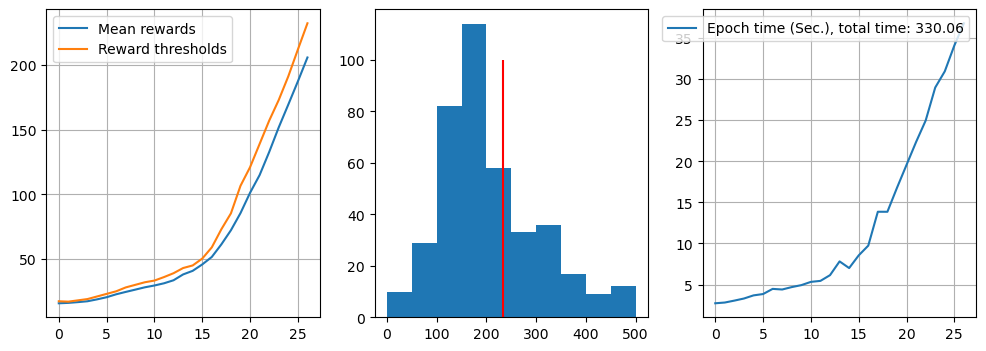

Epoch: 26, mean episode len: 231.56, epoch_time: 36.79581308364868
You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

In [61]:
#%%timeit
n_epochs = 50
n_sessions = 100
percentile = 70

cumulative_data = []
cumulative_len = 3

log = []

#with Parallel(n_jobs=2) as parallel:
for i in range(n_epochs):
    epoch_start_time = time.time()
    # generate new sessions
    #sessions = [generate_session(agent, t_max=500, renderer=False, test=False) for _ in range(0, n_sessions)]
    sessions = Parallel(n_jobs=1)( delayed(generate_session)(agent, t_max=500, 
        renderer=False, test=False, new_environment=True) for _ in range(0, n_sessions))
    #states_batch, actions_batch, rewards_batch, episode_len_batch = map(np.array, zip(*sessions)) #np.array
    states_batch, actions_batch, rewards_batch, episode_len_batch = zip(*sessions)
    #import pdb; pdb.set_trace()
    if cumulative_len > 1:
        if len(cumulative_data) > cumulative_len: 
            cumulative_data = cumulative_data[1:]
        
        cumulative_data.append( (states_batch, actions_batch, rewards_batch) ) 
      #states_batch, actions_batch, rewards_batch = map(np.array, zip(*cumulative_data))
        states_batch, actions_batch, rewards_batch = map(np.concatenate, zip(*cumulative_data))
    
    #import pdb; pdb.set_trace()
    
    elite_states, elite_actions = select_elites(states_batch,
              actions_batch, rewards_batch, percentile) #<select elite actions just like before>
    agent.partial_fit(elite_states, elite_actions)

    epoch_time = time.time() - epoch_start_time
    show_progress(rewards_batch, log, percentile, epoch_time, reward_range=[0, np.max(rewards_batch)])

    print(f'Epoch: {i}, mean episode len: {np.mean(episode_len_batch)}, epoch_time: {epoch_time}')
    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

In [44]:
s1 = ((1,2),(3,4),(5))
s2 = ((6,7),(8,9),(10))
ss = (s1,s2)

d1 = ((11,12),(13,14),(15))
d2 = ((16,17),(18,19),(20))
d3 = ((21,22),(23,24),(25))
dd = (d1,d2,d3)

rr1,tt1,yy1 = map(np.array, zip(*ss))
rr2,tt2,yy2 = map(np.array, zip(*dd))

ll = ((rr1,tt1,yy1 ), map(np.concatenate)
ff1,gg1,hh1 = map(np.concatenate, zip(*ll))
ff1,gg1,hh1

(array([[1, 2],
        [6, 7]]),
 array([[3, 4],
        [8, 9]]),
 array([ 5, 10]))

# Results

In [ ]:
# record sessions
#import env
#env = gym.wrappers.Monitor(gym.make("CartPole-v1"),
#                           directory="videos", force=True)
#sessions = [generate_session(agent, t_max=500, render=False, test=False) for _ in range(100)] #<TRY ARGUMENTS test=True, test=False>
#env.close()
from gym.wrappers import RecordVideo
env.reset()

#from gym.wrappers.monitoring import video_recorder
#vid = video_recorder.VideoRecorder(env=env, base_path="./videos/vid1")

vid = RecordVideo(env=env,video_folder="videos", video_length=1000, new_step_api=True)


gg = generate_session(agent, t_max=1000, renderer=False, test=False, new_environment=False, env=vid)

In [ ]:
!ls ./videos -al

In [ ]:
len(gg[0]), vid.step_id, 

In [3]:
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML
from IPython.display import Video

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[0]  # You can also try other indices

In [ ]:
if True or ('google.colab' in sys.modules):
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
  data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

In [ ]:
video_paths

In [ ]:
%rm ./videos/vid1.meta.json

In [4]:
Video(video_paths[0])

# Homework

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks (up to 10 points)

* __2.1__ Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8) or multiprocessing
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  
  
### Tips
* Gym page: [MountainCar](https://gym.openai.com/envs/MountainCar-v0), [LunarLander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

In [ ]:
def visualize_mountain_car(env, agent):
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    grid = np.dstack(np.meshgrid(xs, vs)).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3)
    return probs

plt.imshow(visualize_mountain_car(env, agent))

### Bonus tasks (up to 5 points)

* __2.3 bonus__ Solve continuous action space task with `MLPRegressor` or similar.
  * Start with ["Pendulum-v0"](https://github.com/openai/gym/wiki/Pendulum-v0).
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Solve [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2). Slightly less points for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules aside from action spaces.
  * __Please list what you did in anytask submission form__